<a href="https://colab.research.google.com/github/sepehrX12/Intrinsic-Alignment-Project/blob/main/CCL_LSST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q condacolab

import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pyccl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _sysroot_linux-64_curr_repodata_hack-3|      h69a702a_16          20 KB  conda-forge
    binutils_impl_linux-64-2.40|       hf600244_0         5.2 MB  conda-forge
    binutils_linux-64-2.40     |       hb3c18ed_0          29 KB  conda-forge

In [1]:
!git clone https://github.com/sepehrX12/Intrinsic-Alignment-Project.git

Cloning into 'Intrinsic-Alignment-Project'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 91 (delta 40), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (91/91), 3.04 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
#%cd Intrinsic-Alignment-Project
!git pull

fatal: not a git repository (or any of the parent directories): .git


In [2]:
!pip install cmasher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 3.2 MB/s eta 0:00:00


In [3]:
import sys
sys.path.append('/content/Intrinsic-Alignment-Project')

In [4]:
import binning
import srd_redshift_distributions

In [5]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
from srd_redshift_distributions import SRDRedshiftDistributions
from binning import Binning

In [6]:
# Create new Cosmology object with a given set of parameters. This keeps track
# of previously-computed cosmological functions
params = {'Omega_c': 0.22, 'Omega_b': 0.048, 'h':0.71, 'sigma8':0.8, 'n_s':0.963,
    'transfer_function':'bbks'}
cosmo = ccl.Cosmology(**params)

# Define a simple binned galaxy number density curve as a function of redshift
z_n = np.linspace(0., 1., 500)
n = np.ones(z_n.shape)

# Create objects to represent tracers of the weak lensing signal with this
# number density (with has_intrinsic_alignment=False)
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z_n, n))
lens2 = ccl.WeakLensingTracer(cosmo, dndz=(z_n, n))

# Calculate the angular cross-spectrum of the two tracers as a function of ell
ell = np.arange(2, 10)
cls = cosmo.angular_cl(lens1, lens2, ell)
print(cls)

[8.47652522e-09 1.13706674e-08 1.24468900e-08 1.27641166e-08
 1.27180461e-08 1.24858410e-08 1.21564271e-08 1.17779668e-08]


In [7]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.0, 3, 512)
forecast_years = ["1", "10"]  # LSST forecasting epochs

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

for year in forecast_years:
    source_dist = SRDRedshiftDistributions(redshift_range,
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = SRDRedshiftDistributions(redshift_range,
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=True,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=True,
                                                                                save_file=False)

# Uncomment to check if the dictionary is populated correctly
print(redshift_distribution["sources"].keys())

dict_keys(['1', '10'])


In [8]:
# Set global line width and font sizes
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 15

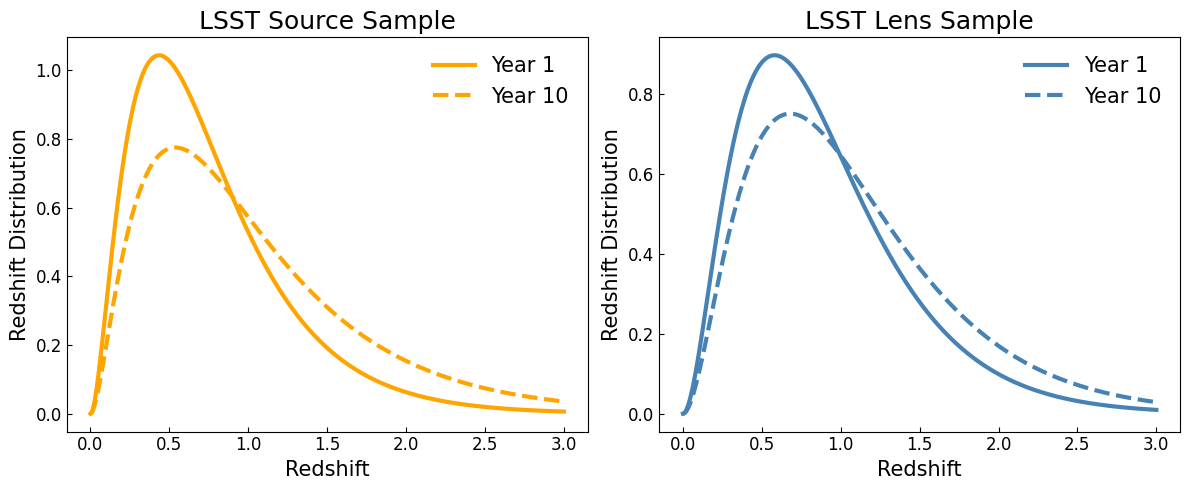

In [9]:
# Define the colors and sample types
colors = {'sources': 'orange',
          'lenses': 'steelblue'}
sample_types = ['sources', 'lenses']
titles = {'sources': 'LSST Source Sample',
          'lenses': 'LSST Lens Sample'}

# Create 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Loop through sample types to create the plots
for ax, sample_type in zip(axs, sample_types):
    ax.plot(redshift_range, redshift_distribution[sample_type]['1'], label='Year 1', linestyle='-', color=colors[sample_type])
    ax.plot(redshift_range, redshift_distribution[sample_type]['10'], label='Year 10', linestyle='--', color=colors[sample_type])
    ax.set_title(titles[sample_type])
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Redshift Distribution')
    ax.tick_params(direction='in')
    ax.legend(frameon=False)

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
# Define a dictionary to store the bins
bins = {
    "sources": {},
    "lenses": {}
}
# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = Binning(redshift_range,
                                    redshift_distribution["sources"][year],
                                    year).source_bins(normalised=True,
                                                      save_file=False)
    bins["lenses"][year] = Binning(redshift_range,
                                   redshift_distribution["lenses"][year],
                                   year).lens_bins(normalised=True,
                                                   save_file=False)

In [11]:
# Define colors for plots
lens_colors = {
    "1": cmr.take_cmap_colors('cmr.freeze',
                              len(bins["lenses"]["1"]),
                              cmap_range=(0.2, 0.85),
                              return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.freeze', len(bins["lenses"]["10"]), cmap_range=(0.2, 0.85), return_fmt='hex')
}

source_colors = {
    "1": cmr.take_cmap_colors('cmr.ember',
                              len(bins["sources"]["1"]),
                              cmap_range=(0.2, 0.85),
                              return_fmt='hex'),
    "10": cmr.take_cmap_colors('cmr.ember',
                               len(bins["sources"]["10"]),
                               cmap_range=(0.2, 0.85),
                               return_fmt='hex')
}

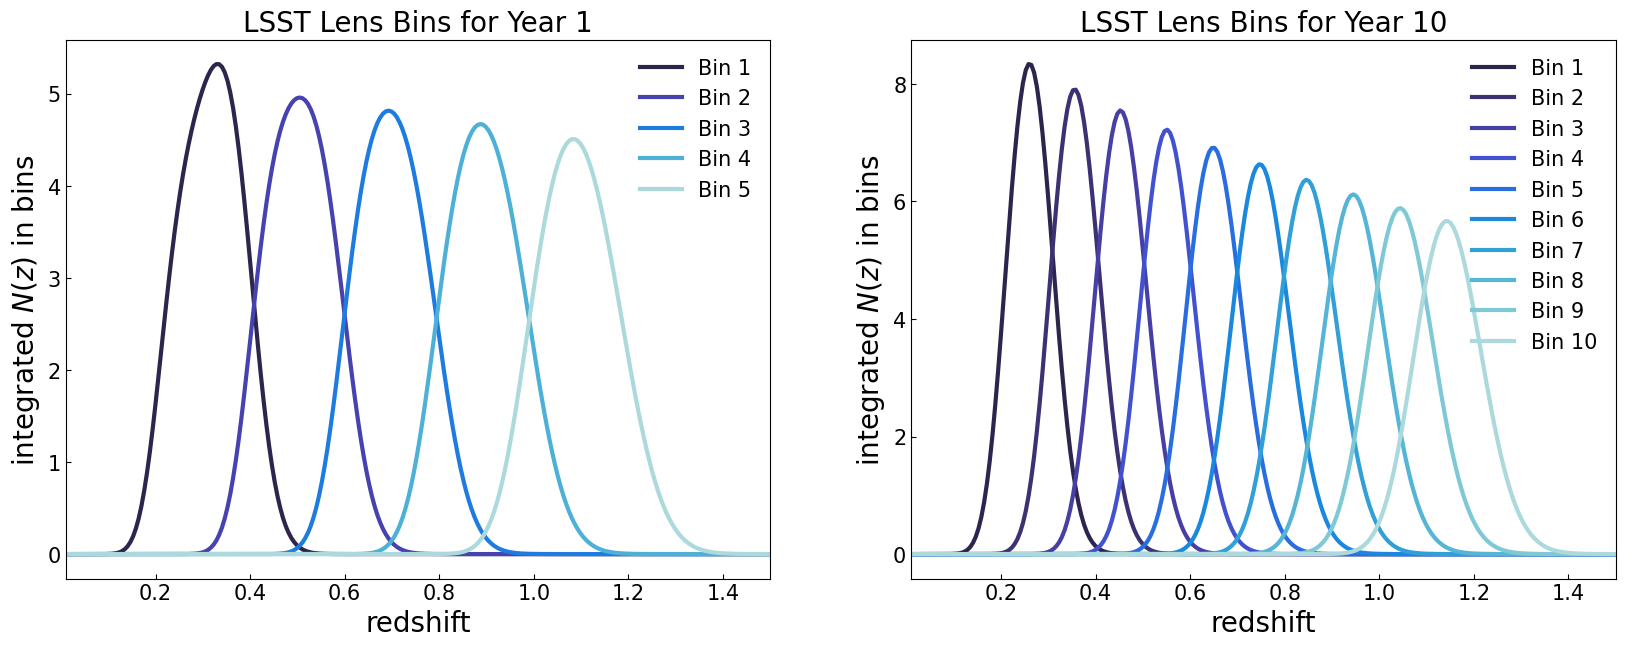

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

for idx, year in enumerate(forecast_years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1}",
                color=lens_colors[year][bin_idx])
        ax.set_xlim(0.01, 1.5)
        ax.set_xlabel("redshift", fontsize=20)
        ax.set_ylabel("integrated $N(z)$ in bins", fontsize=20)
        ax.set_title(f"LSST Lens Bins for Year {year}", fontsize=20)
        ax.tick_params(direction='in')
        ax.legend(frameon=False, ncol=1)
        ax.tick_params(axis='both', which='major', labelsize=15)

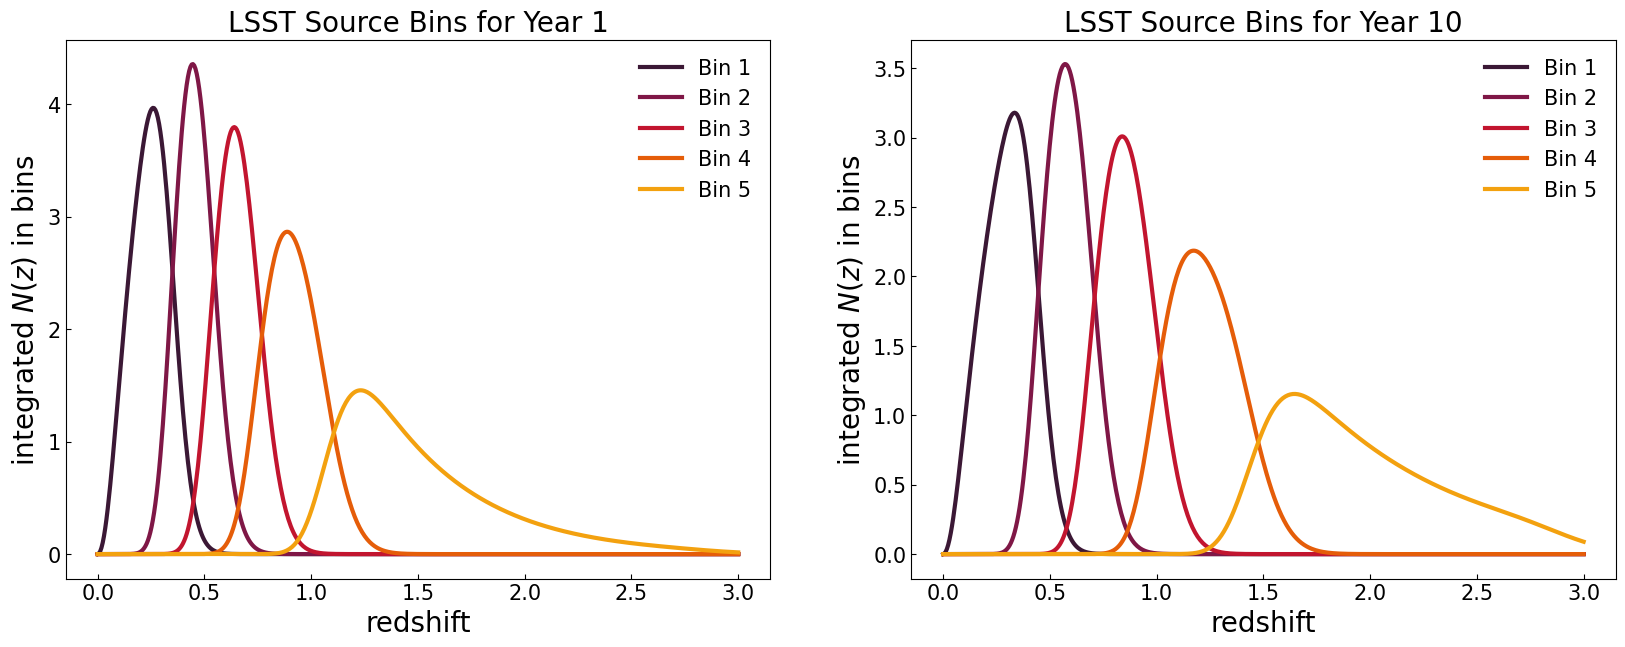

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))

for idx, year in enumerate(forecast_years):
    ax = axes[idx]
    for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1}",
                color=source_colors[year][bin_idx])
        ax.set_xlabel("redshift", fontsize=20)
        ax.set_ylabel("integrated $N(z)$ in bins", fontsize=20)
        ax.set_title(f"LSST Source Bins for Year {year}", fontsize=20)
        ax.tick_params(direction='in')
        ax.legend(frameon=False, ncol=1)
        ax.tick_params(axis='both', which='major', labelsize=15)

In [14]:
bin_centers_y1 = Binning(redshift_range,
                         redshift_distribution["sources"]["1"],
                         "1").get_bin_centers(save_file=False, decimal_places=2)

bin_centers_y10 = Binning(redshift_range,
                          redshift_distribution["sources"]["10"],
                          "10").get_bin_centers(save_file=False, decimal_places=2)

print(bin_centers_y1.keys())
print(bin_centers_y10.keys())
print(f"bin centers for sources year 1: {bin_centers_y1['sources']}, \n bin centers for lenses year 1: {bin_centers_y1['lenses']}")
print(f"bin centers for sources year 10: {bin_centers_y10['sources']}, \n bin centers for lenses year 10: {bin_centers_y10['lenses']}")

dict_keys(['sources', 'lenses'])
dict_keys(['sources', 'lenses'])
bin centers for sources year 1: [0.26, 0.45, 0.64, 0.89, 1.23], 
 bin centers for lenses year 1: [0.32, 0.49, 0.69, 0.88, 1.08]
bin centers for sources year 10: [0.33, 0.57, 0.84, 1.17, 1.64], 
 bin centers for lenses year 10: [0.26, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.14]


Now to calculate 2 point correlation functions for the cosmology.

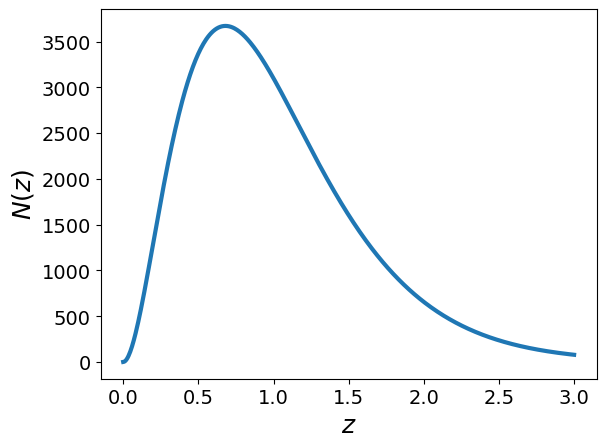

In [15]:
z = np.linspace(0., 3., 512)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution
b = [1.229*np.ones(512),
     1.362*np.ones(512),
     1.502*np.ones(512),
     1.648*np.ones(512),
     1.799*np.ones(512)] #Galaxy bias (constant with scale and z)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()

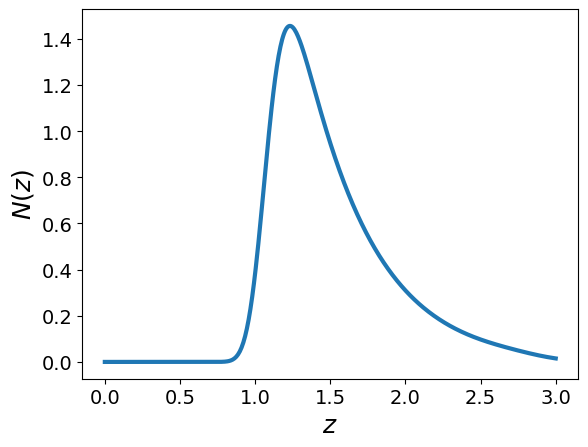

In [16]:
z = np.linspace(0., 3., 512)

 # Redshift distribution, p(z)
pz = bins['sources']['1'][4]
dNdz = pz # Number density distribution
b = [1.229*np.ones(512),
     1.362*np.ones(512),
     1.502*np.ones(512),
     1.648*np.ones(512),
     1.799*np.ones(512)] #Galaxy bias (constant with scale and z)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()

In [16]:
ell = np.arange(2, 2000)
# dict of tracers
tracer_dict = {
    "G": [], # shear
    "N": []  # clustering
}
for i in range(5):
  tracer_dict["G"].append(ccl.WeakLensingTracer(cosmo, dndz=(z, bins["sources"]['1'][i])))
  tracer_dict["N"].append(ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, bins["lenses"]['1'][i]), bias=(z,b[i])))
# dict of C_ell's without IA
C_ell_dict = {
    "GG": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []},
    "NG": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []},
    "NN": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []}
}
for key in C_ell_dict.keys():
  for k in C_ell_dict[key].keys():
    C_ell_dict[key][k] = ccl.angular_cl(cosmo, tracer_dict[key[0]][int(k[0])-1], tracer_dict[key[1]][int(k[1])-1], ell)

In [26]:
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz)) #CCL automatically normalizes dNdz
clu1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b[1]))
# with IA
bias_ia = 1*np.ones_like(z) #A_IA=1 in the NLA model
lens1_ia = ccl.WeakLensingTracer(cosmo, dndz = (z,dNdz), ia_bias = (z,bias_ia))

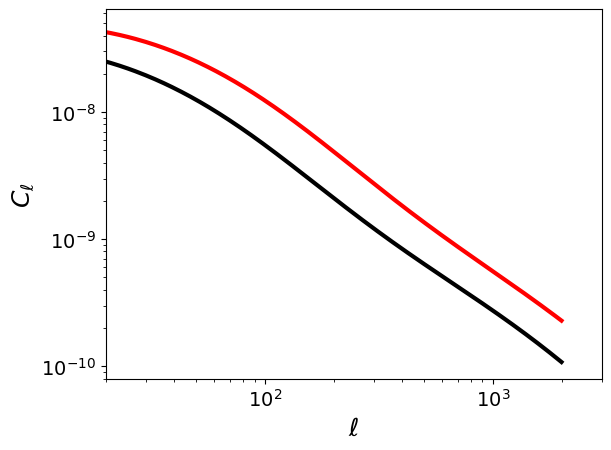

In [ ]:
# angular power spectra - Cell
ell = np.arange(2, 2000)

cls = ccl.angular_cl(cosmo, lens1, lens1, ell) #Cosmic shear
cls_ia = ccl.angular_cl(cosmo, lens1_ia, lens1_ia, ell) #Cosmic shear with IA
cls_clu = ccl.angular_cl(cosmo, clu1, clu1, ell) #Clustering

plt.xlabel('$\ell$',fontsize=18)
plt.ylabel('$C_\ell$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(2.e1,3.e3)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, C_ell_dict['GG']['44'], 'k-')
plt.plot(ell, cls_ia, 'r-')
plt.show()

In [ ]:
# now to calculate the correlation functions.
theta_deg = np.logspace(-1, np.log10(5.), 30) # Theta is in degrees
theta_minutes = np.logspace(np.log10(1), np.log10(3.e2), 30) # Theta is in minutes
theta_deg = np.logspace(np.log10(1/60), np.log10(3.e2/60), 30)
#Cosmic shear:
xi_plus = ccl.correlation(cosmo, ell=ell, C_ell=cls, theta=theta_deg, type='GG+', method='FFTLog')
xi_minus = ccl.correlation(cosmo, ell=ell, C_ell=cls, theta=theta_deg, type='GG-', method='FFTLog')
#Cosmic shear with IA:
xi_plus_ia = ccl.correlation(cosmo, ell=ell, C_ell=cls_ia, theta=theta_deg, type='GG+', method='FFTLog')
xi_minus_ia = ccl.correlation(cosmo, ell=ell, C_ell=cls_ia, theta=theta_deg, type='GG-', method='FFTLog')
#Clustering:
xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cls_clu, theta=theta_deg, type='NN', method='FFTLog')

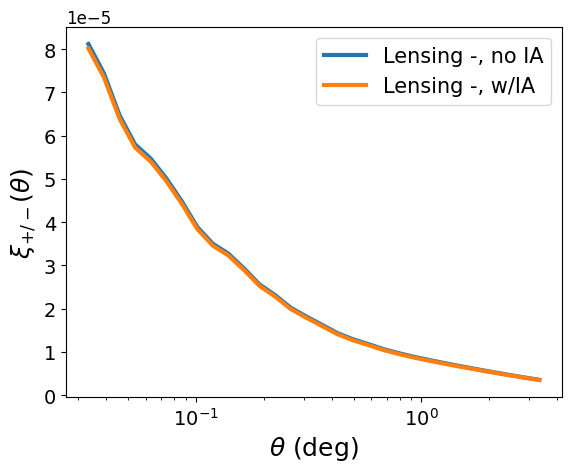

In [ ]:
#plt.plot(theta_deg, xi_plus, label='Lensing +, no IA')
plt.plot(theta_deg, xi_minus, label='Lensing -, no IA')
#plt.plot(theta_deg, xi_plus_ia, label='Lensing +, w/IA')
plt.plot(theta_deg, xi_minus_ia, label='Lensing -, w/IA')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$\xi_{+/-} (\theta)$',fontsize=18)
plt.show()

In [ ]:
xi_dict = {
    "GG": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []},
    "NG": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []},
    "NN": {"11": [], "12": [], "13": [], "14": [], "15": [],
           "22": [], "23": [], "24": [], "25": [],
           "33": [], "34": [], "35": [],
           "44": [], "45": [],
           "55": []}
}
for key in xi_dict.keys():
  for k in xi_dict[key].keys():
    if (key == "GG"):
      xi_dict[key][k] = (ccl.correlation(cosmo, ell=ell, C_ell=C_ell_dict[key][k], theta=theta_deg, type='GG+', method='FFTLog') ,
      ccl.correlation(cosmo, ell=ell, C_ell=C_ell_dict[key][k], theta=theta_deg, type='GG-', method='FFTLog'))
    else:
      xi_dict[key][k] = ccl.correlation(cosmo, ell=ell, C_ell=C_ell_dict[key][k], theta=theta_deg, type=key, method='FFTLog')

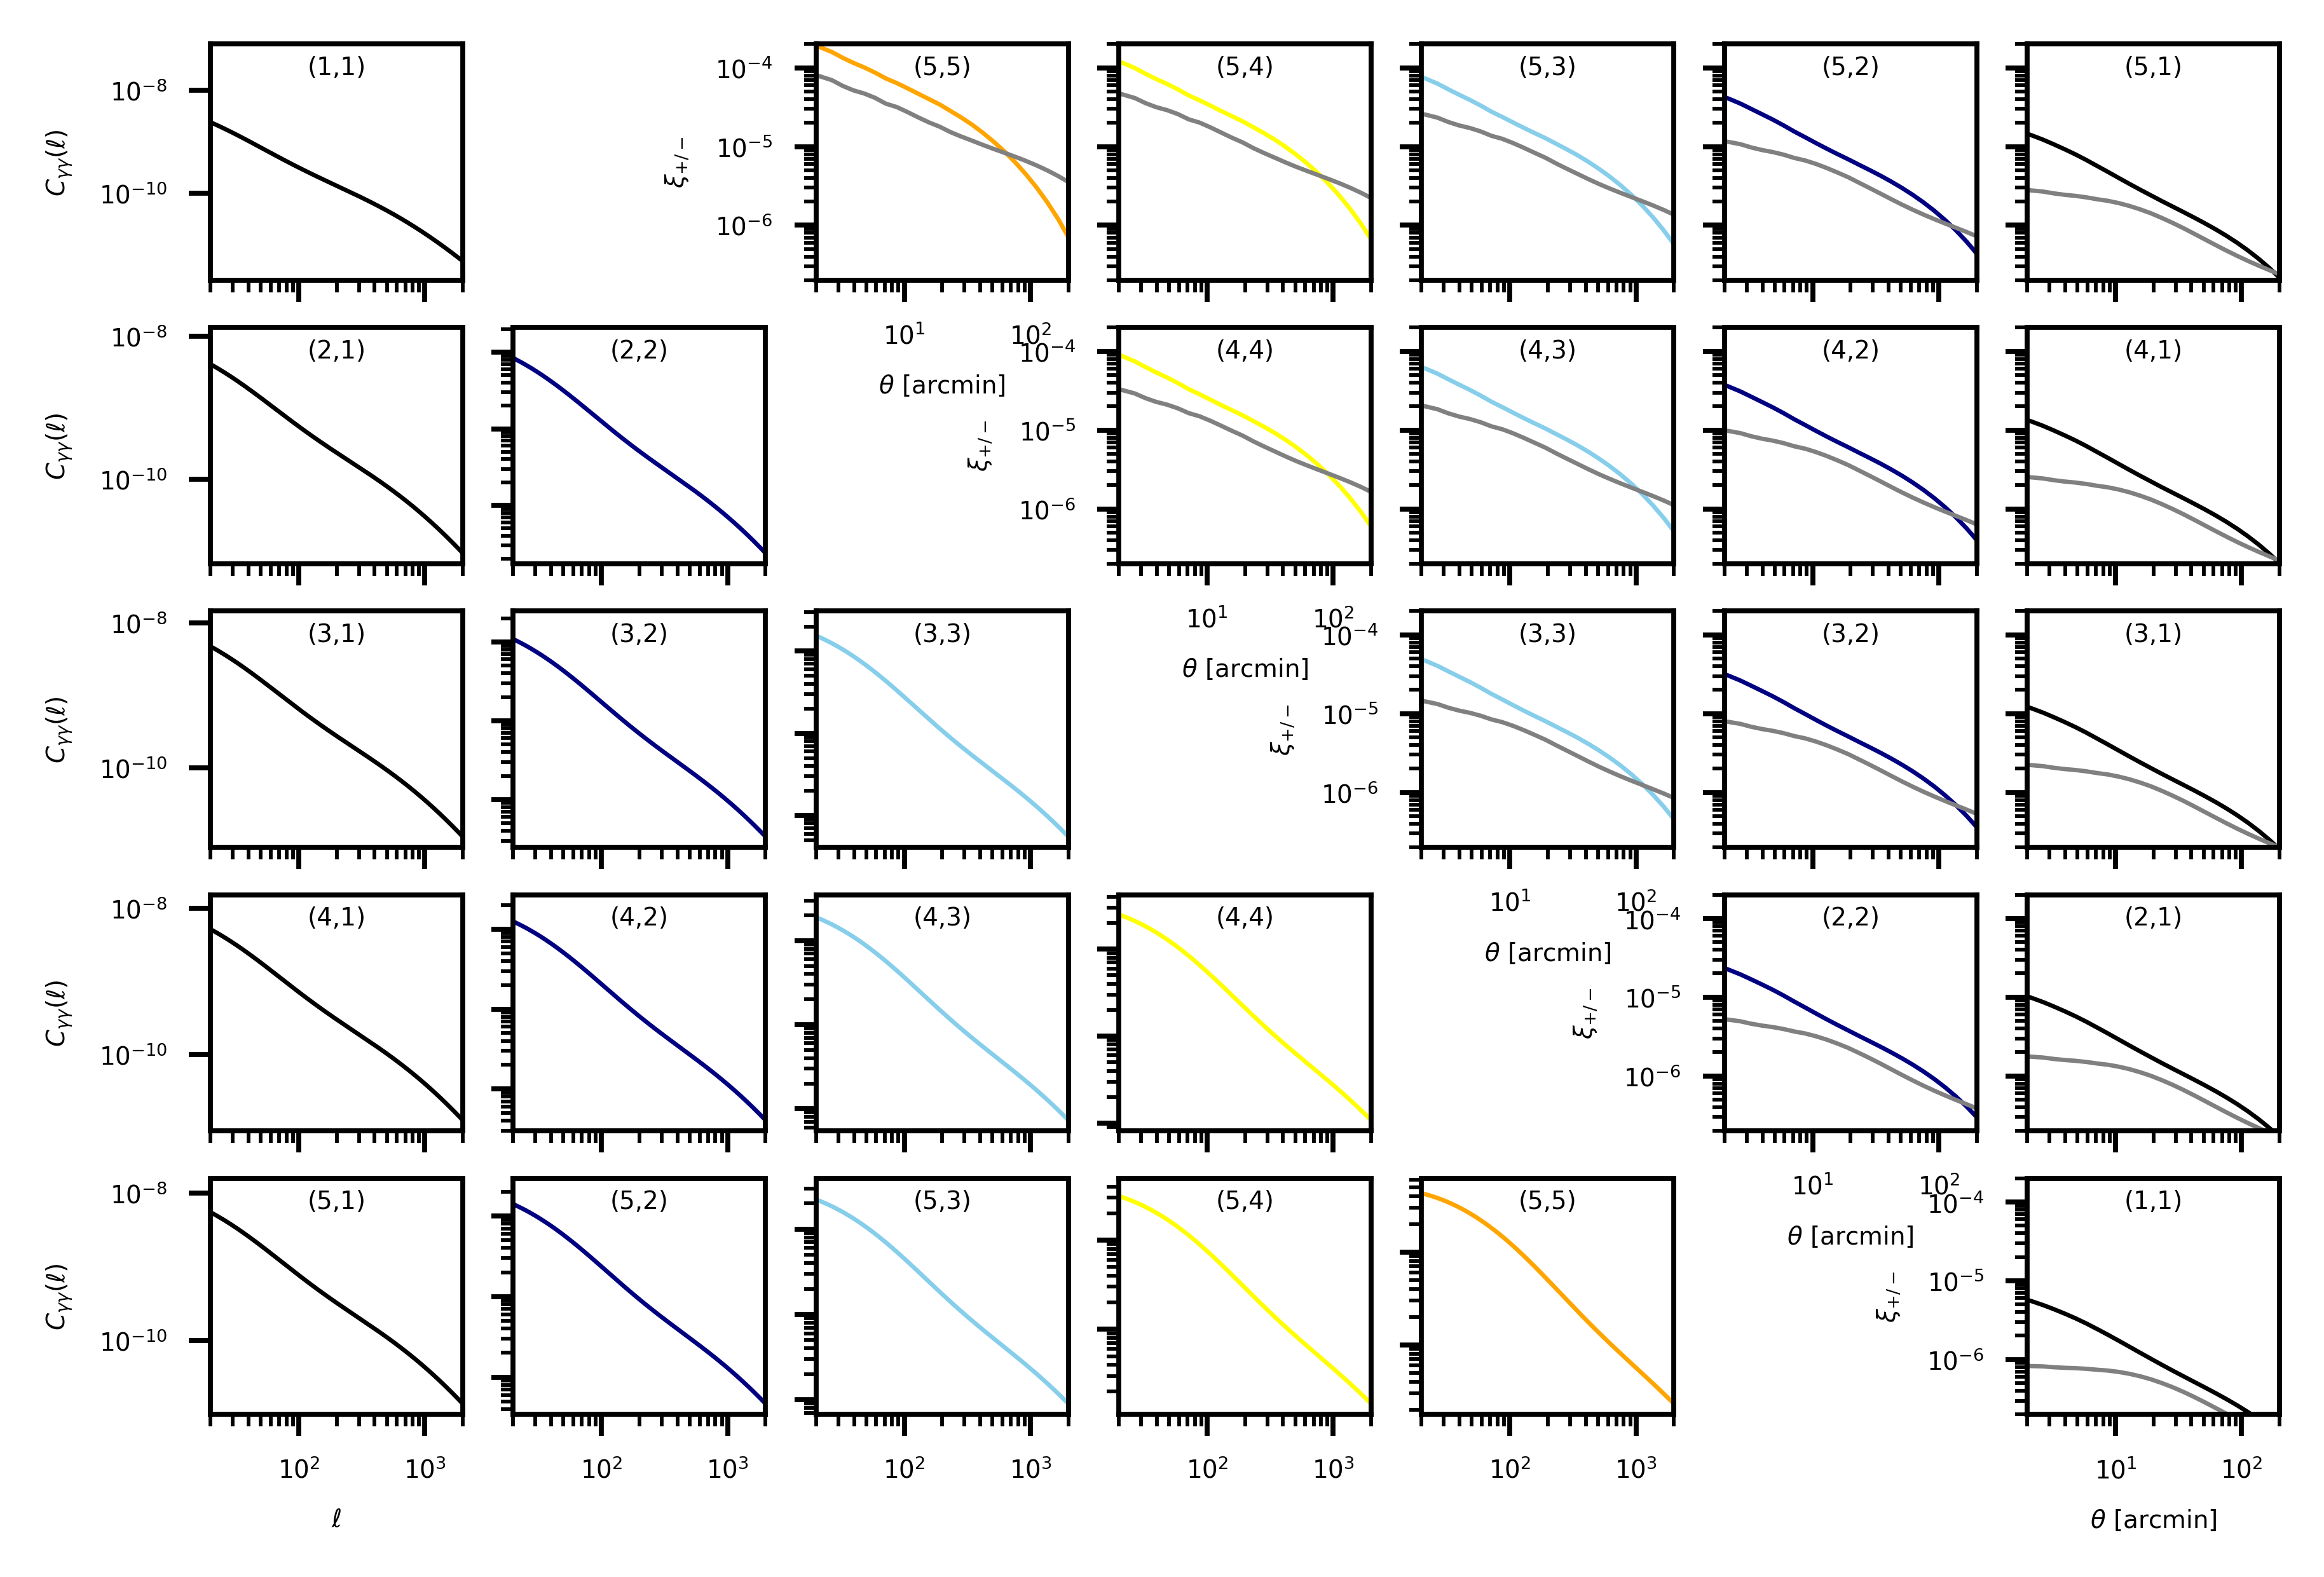

In [ ]:
#plt.plot(theta_deg, xi_plus, label='Lensing +, no IA')
lw = 0.7
fs = 4
x = .5
y= .9

plt.figure(figsize=(6,4), dpi=700)

# C_yy_11
plt.subplot(5,7,1)
plt.text(x, y, '(1,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['11'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylim(2.e-12,8.e-8)
plt.xlim(2.e1,2.e3)
plt.xlabel(r'$\ell$', fontsize = fs)
plt.ylabel(r'$C_{\gamma\gamma} (\ell)$', fontsize=fs)
plt.gca().set_xticklabels([])
plt.yticks(fontsize=fs)

# xi_55
plt.subplot(5,7,3)
plt.text(x, y, '(5,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["55"][0], linewidth=lw, color='orange')
plt.plot(theta_minutes, xi_dict["GG"]["55"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\xi_{+/-}$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)

# xi_54
plt.subplot(5,7,4)
plt.text(x, y, '(5,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["45"][0], linewidth=lw, color='yellow')
plt.plot(theta_minutes, xi_dict["GG"]["45"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
# xi_53
plt.subplot(5,7,5)
plt.text(x, y, '(5,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["35"][0], linewidth=lw, color='skyblue')
plt.plot(theta_minutes, xi_dict["GG"]["35"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
# xi_52
plt.subplot(5,7,6)
plt.text(x, y, '(5,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["25"][0], linewidth=lw, color='navy')
plt.plot(theta_minutes, xi_dict["GG"]["25"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
# xi_51
plt.subplot(5,7,7)
plt.text(x, y, '(5,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["15"][0], linewidth=lw, color='black')
plt.plot(theta_minutes, xi_dict["GG"]["15"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
#################################
# C_yy_21
plt.subplot(5,7,8)
plt.text(x, y, '(2,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['12'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{\gamma\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.xlim(2.e1,2.e3)

# C_yy_22
plt.subplot(5,7,9)
plt.text(x, y, '(2,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['22'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# xi_44
plt.subplot(5,7,11)
plt.text(x, y, '(4,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["44"][0], linewidth=lw, color='yellow')
plt.plot(theta_minutes, xi_dict["GG"]["44"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\xi_{+/-}$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)

# xi_43
plt.subplot(5,7,12)
plt.text(x, y, '(4,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["34"][0], linewidth=lw, color='skyblue')
plt.plot(theta_minutes, xi_dict["GG"]["34"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
# xi_42
plt.subplot(5,7,13)
plt.text(x, y, '(4,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["24"][0], linewidth=lw, color='navy')
plt.plot(theta_minutes, xi_dict["GG"]["24"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
# xi_41
plt.subplot(5,7,14)
plt.text(x, y, '(4,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["14"][0], linewidth=lw, color='black')
plt.plot(theta_minutes, xi_dict["GG"]["14"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
###############################
# C_yy_31
plt.subplot(5,7,15)
plt.text(x, y, '(3,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['13'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize = fs)
plt.ylabel(r'$C_{\gamma\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2.e1,2.e3)
plt.gca().set_xticklabels([])

# C_yy_32
plt.subplot(5,7,16)
plt.text(x, y, '(3,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['23'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# C_yy_33
plt.subplot(5,7,17)
plt.text(x, y, '(3,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['33'] , linewidth = lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# xi_33
plt.subplot(5,7,19)
plt.text(x, y, '(3,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["33"][0], linewidth=lw, color='skyblue')
plt.plot(theta_minutes, xi_dict["GG"]["33"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\xi_{+/-}$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)

# xi_32
plt.subplot(5,7,20)
plt.text(x, y, '(3,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["23"][0], linewidth=lw, color='navy')
plt.plot(theta_minutes, xi_dict["GG"]["23"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
# xi_31
plt.subplot(5,7,21)
plt.text(x, y, '(3,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["13"][0], linewidth=lw, color='black')
plt.plot(theta_minutes, xi_dict["GG"]["13"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)
#############################
# C_yy_41
plt.subplot(5,7,22)
plt.text(x, y, '(4,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['14'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize = fs)
plt.ylabel(r'$C_{\gamma\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.xlim(2.e1,2.e3)

# C_yy_42
plt.subplot(5,7,23)
plt.text(x, y, '(4,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['24'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# C_yy_43
plt.subplot(5,7,24)
plt.text(x, y, '(4,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['34'] , linewidth = lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# C_yy_44
plt.subplot(5,7,25)
plt.text(x, y, '(4,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['44'] , linewidth = lw, color='yellow')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# xi_22
plt.subplot(5,7,27)
plt.text(x, y, '(2,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["22"][0], linewidth=lw, color='navy')
plt.plot(theta_minutes, xi_dict["GG"]["22"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\xi_{+/-}$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)

# xi_21
plt.subplot(5,7,28)
plt.text(x, y, '(2,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["12"][0], linewidth=lw, color='black')
plt.plot(theta_minutes, xi_dict["GG"]["12"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)

######################
# C_yy_51
plt.subplot(5,7,29)
plt.text(x, y, '(5,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['15'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize = fs)
plt.ylabel(r'$C_{\gamma\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2.e1,2.e3)

# C_yy_52
plt.subplot(5,7,30)
plt.text(x, y, '(5,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['25'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_yticklabels([])
plt.xticks(fontsize=fs)
plt.xlim(2.e1,2.e3)

# C_yy_53
plt.subplot(5,7,31)
plt.text(x, y, '(5,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['35'] , linewidth = lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_yticklabels([])
plt.xticks(fontsize=fs)
plt.xlim(2.e1,2.e3)

# C_yy_54
plt.subplot(5,7,32)
plt.text(x, y, '(5,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['45'] , linewidth = lw, color='yellow')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_yticklabels([])
plt.xticks(fontsize=fs)
plt.xlim(2.e1,2.e3)

# C_yy_55
plt.subplot(5,7,33)
plt.text(x, y, '(5,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['GG']['55'] , linewidth = lw, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_yticklabels([])
plt.xticks(fontsize=fs)
plt.xlim(2.e1,2.e3)

# xi_11
plt.subplot(5,7,35)
plt.text(x, y, '(1,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["GG"]["11"][0], linewidth=lw, color='black')
plt.plot(theta_minutes, xi_dict["GG"]["11"][1], linewidth=lw, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\xi_{+/-}$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylim(2.e-7,2.e-4)
plt.xlim(2,2.e2)

plt.show()

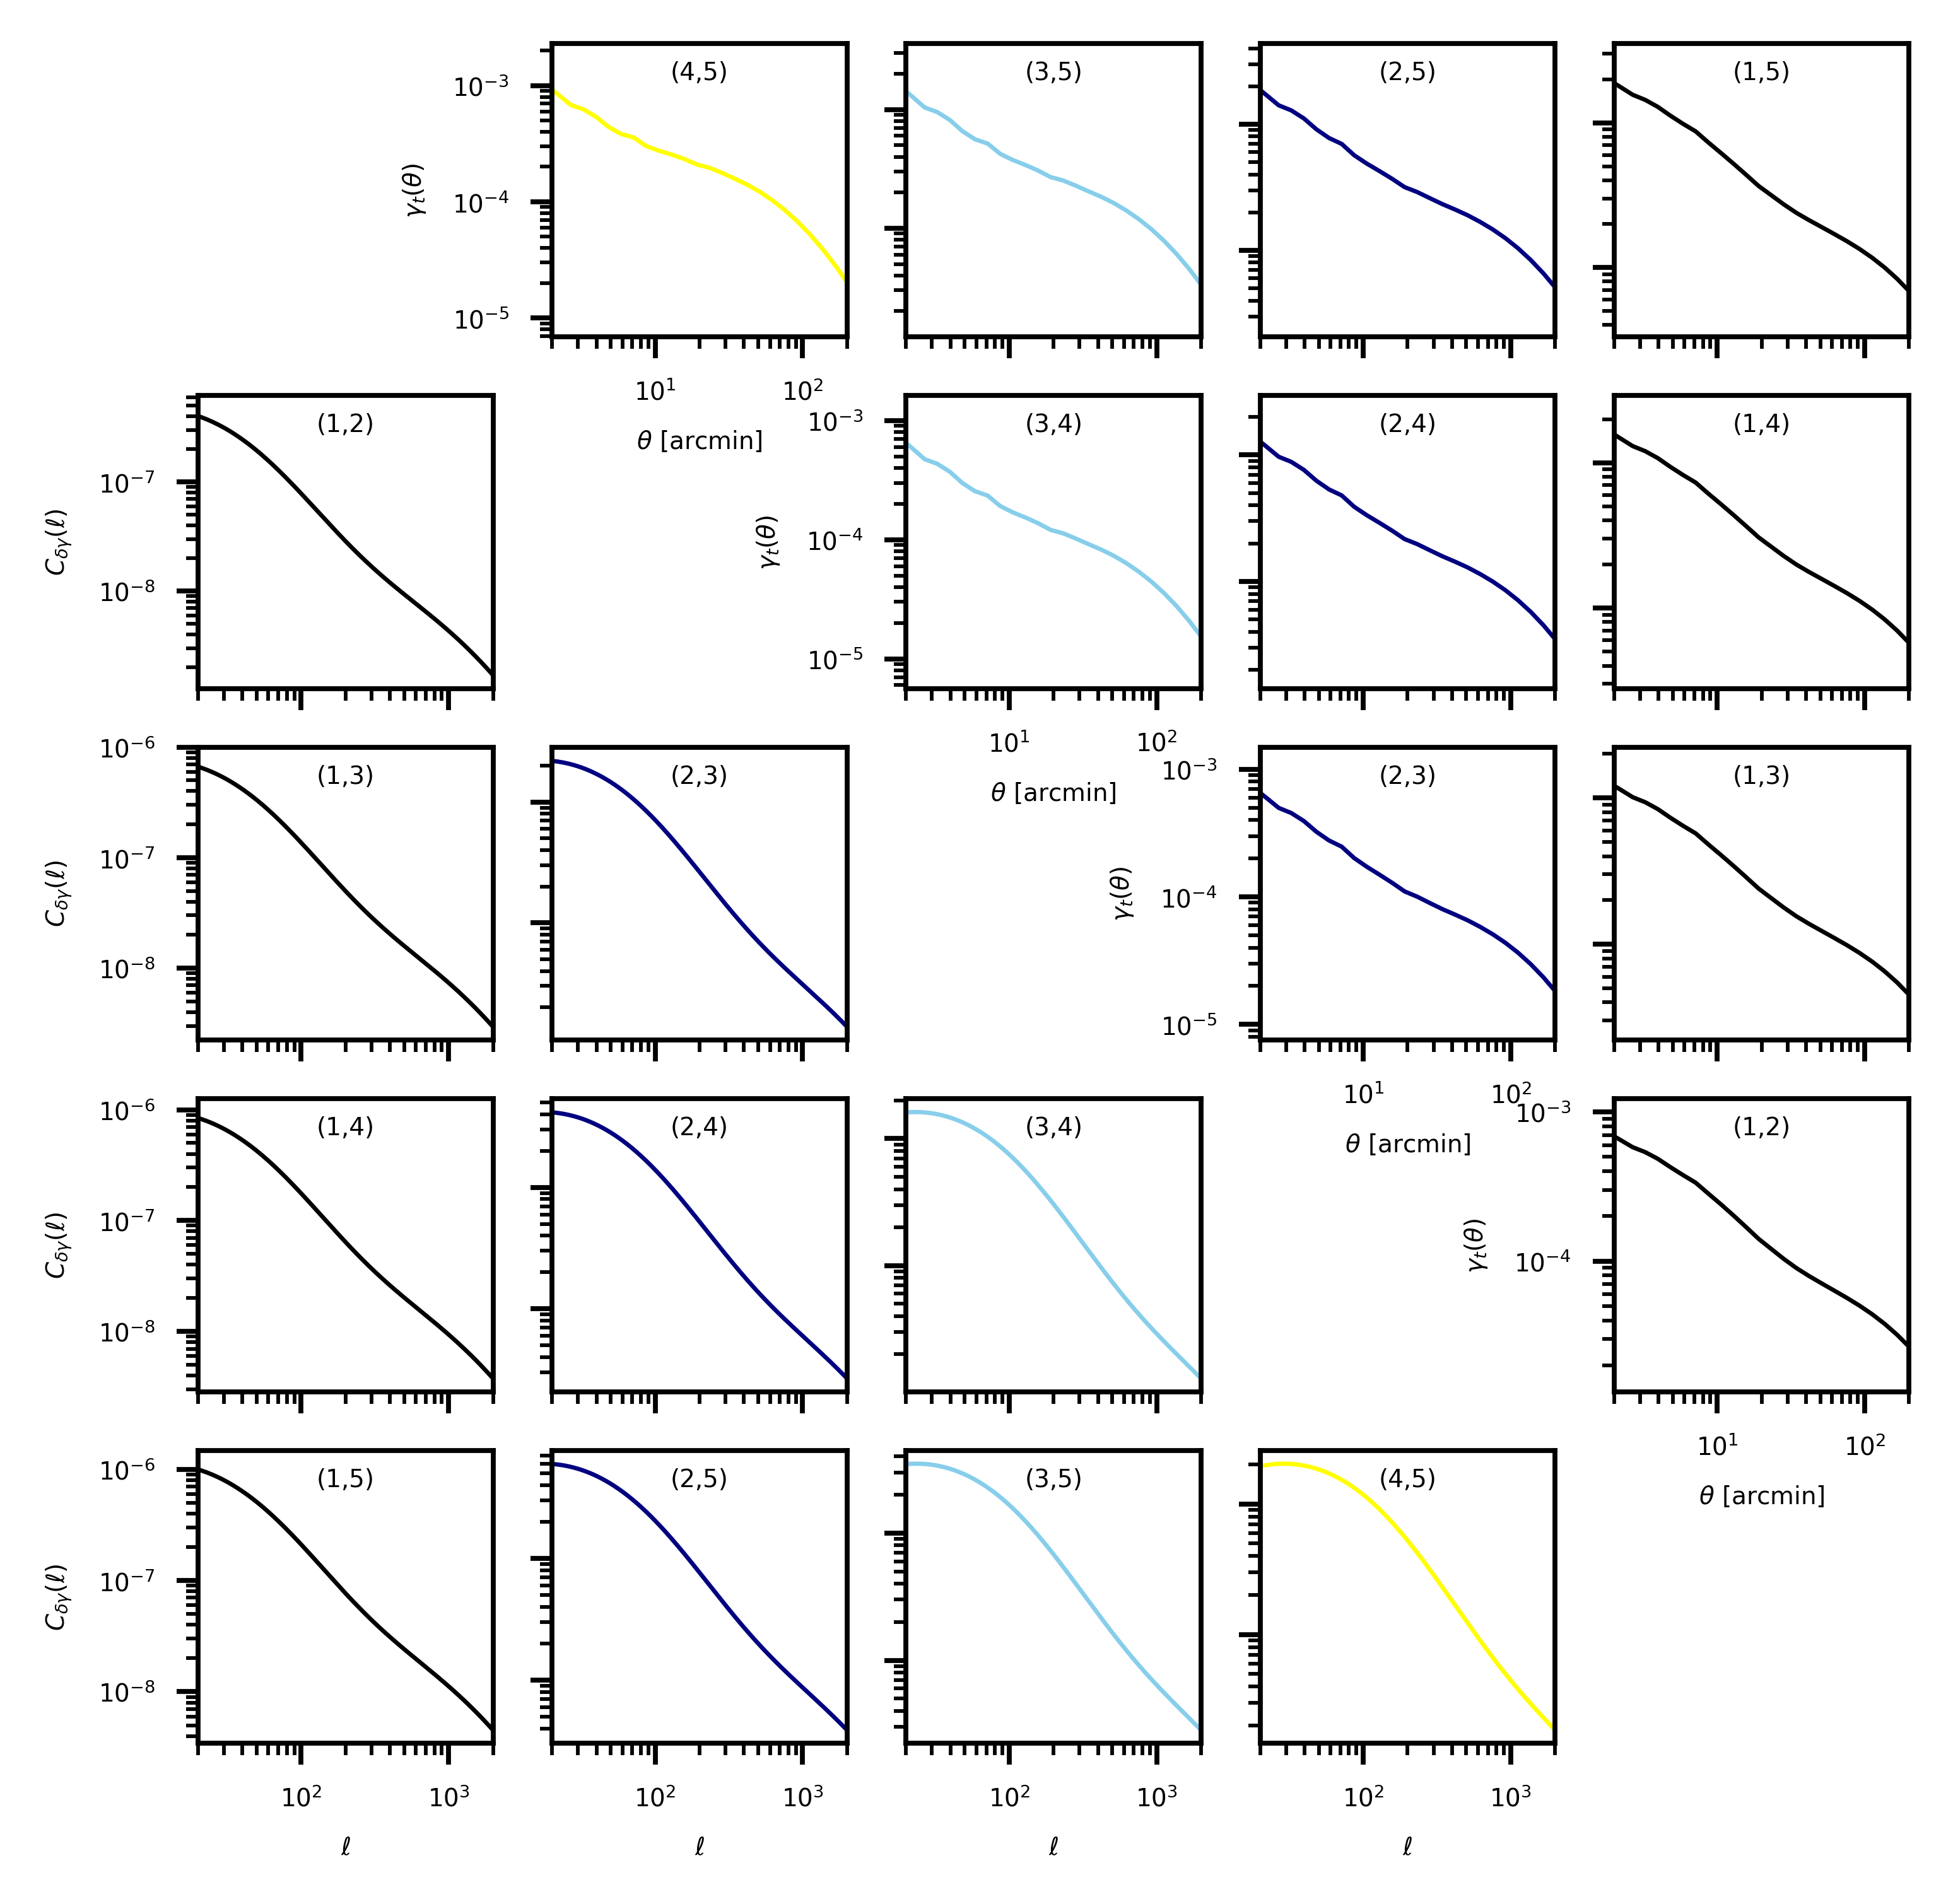

In [ ]:
# C_gy plots
lw = 0.7
fs = 4
x = .5
y= .9

plt.figure(figsize=(5,5), dpi=700)

# xi_45
plt.subplot(5,5,2)
plt.text(x, y, '(4,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["45"], linewidth=lw, color='yellow')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\gamma_{t}(\theta)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

# xi_35
plt.subplot(5,5,3)
plt.text(x, y, '(3,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["35"], linewidth=lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2,2.e2)
# xi_25
plt.subplot(5,5,4)
plt.text(x, y, '(2,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["25"], linewidth=lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2,2.e2)
# xi_15
plt.subplot(5,5,5)
plt.text(x, y, '(1,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["15"], linewidth=lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2,2.e2)

#################################
# C_gy_12
plt.subplot(5,5,6)
plt.text(x, y, '(1,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['12'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{\delta\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.xlim(2.e1,2.e3)

# xi_34
plt.subplot(5,5,8)
plt.text(x, y, '(3,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["34"], linewidth=lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\gamma_{t}(\theta)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

# xi_24
plt.subplot(5,5,9)
plt.text(x, y, '(2,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["24"], linewidth=lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2,2.e2)
# xi_14
plt.subplot(5,5,10)
plt.text(x, y, '(1,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["14"], linewidth=lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2,2.e2)

###############################
# C_gy_13
plt.subplot(5,5,11)
plt.text(x, y, '(1,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['13'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{\delta\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.xlim(2.e1,2.e3)

# C_gy_23
plt.subplot(5,5,12)
plt.text(x, y, '(2,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['23'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# xi_23
plt.subplot(5,5,14)
plt.text(x, y, '(2,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["23"], linewidth=lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\gamma_{t}(\theta)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

# xi_13
plt.subplot(5,5,15)
plt.text(x, y, '(1,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["13"], linewidth=lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2,2.e2)

#############################
# C_gy_14
plt.subplot(5,5,16)
plt.text(x, y, '(1,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['14'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{\delta\gamma} (\ell)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.xlim(2.e1,2.e3)

# C_gy_24
plt.subplot(5,5,17)
plt.text(x, y, '(2,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['24'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# C_gy_34
plt.subplot(5,5,18)
plt.text(x, y, '(3,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['34'] , linewidth = lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# xi_12
plt.subplot(5,5,20)
plt.text(x, y, '(1,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NG"]["12"], linewidth=lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$\gamma_{t}(\theta)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

######################
# C_gy_15
plt.subplot(5,5,21)
plt.text(x, y, '(1,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['15'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{\delta\gamma} (\ell)$', fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2.e1,2.e3)

# C_gy_25
plt.subplot(5,5,22)
plt.text(x, y, '(2,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['25'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# C_gy_35
plt.subplot(5,5,23)
plt.text(x, y, '(3,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['35'] , linewidth = lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

# C_gy_45
plt.subplot(5,5,24)
plt.text(x, y, '(4,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NG']['45'] , linewidth = lw, color='yellow')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)

plt.show()

(4e-08, 0.0001)

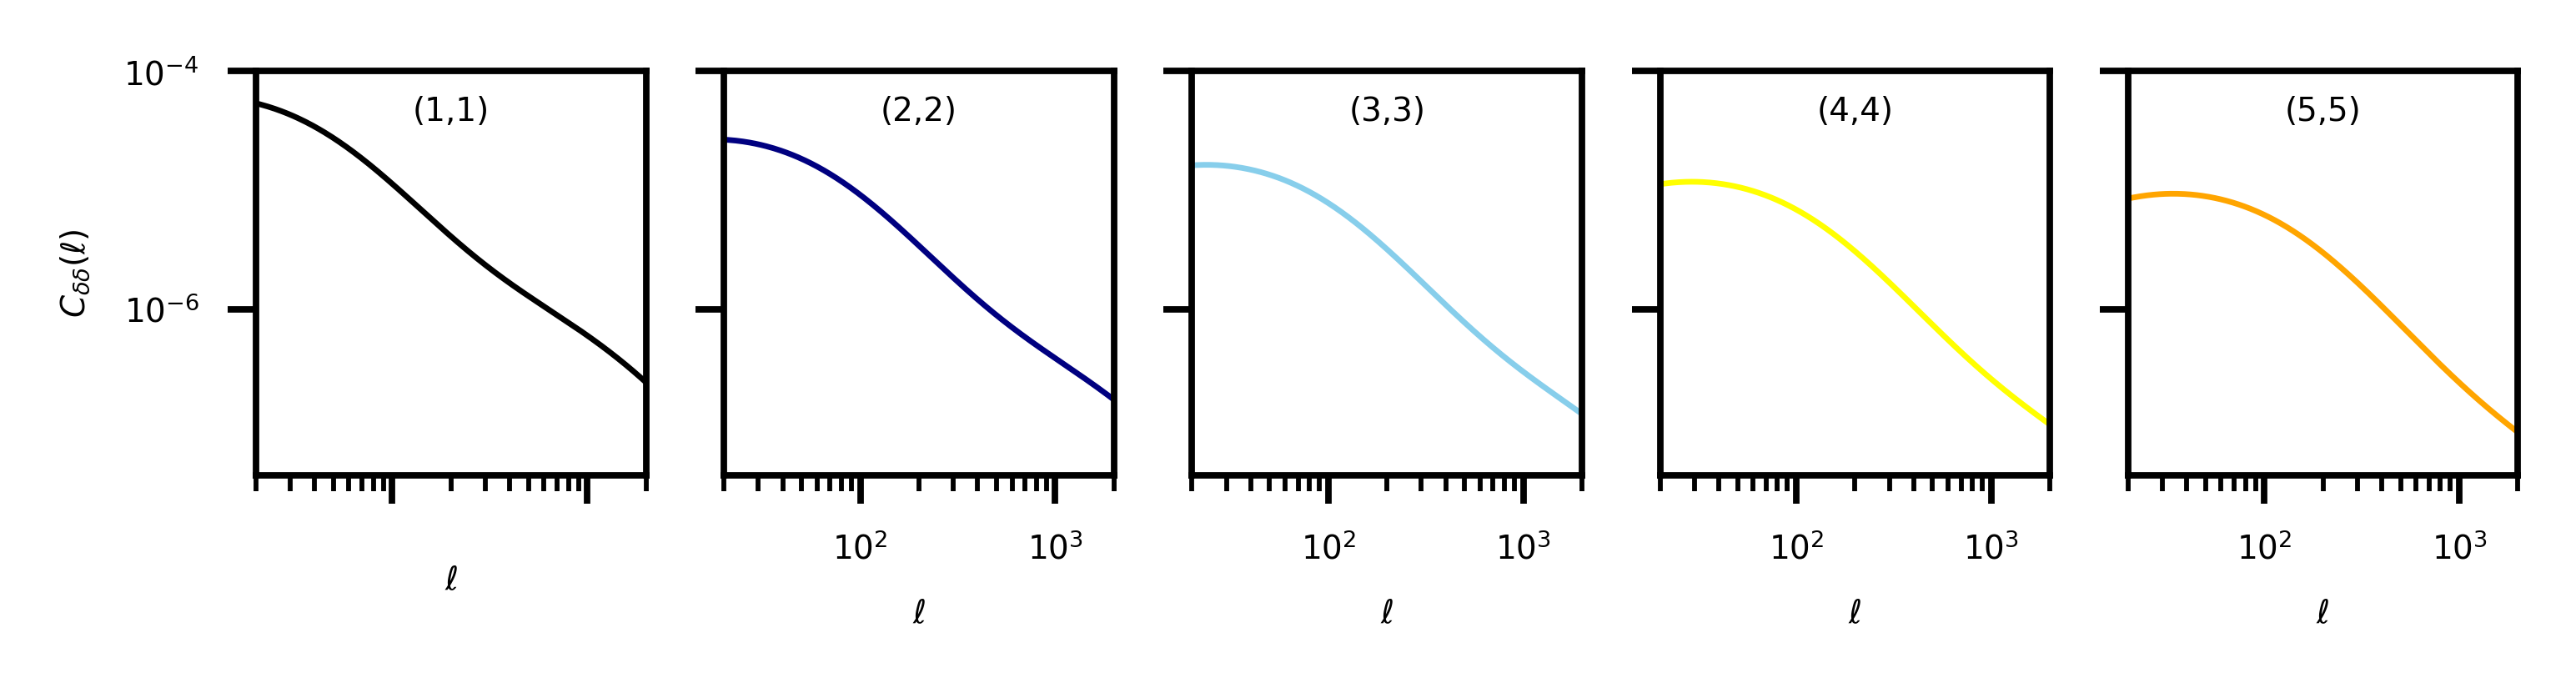

In [ ]:
# C_gg
lw = 0.7
fs = 4
x = .5
y= .9

plt.figure(figsize=(5,0.9), dpi=700)

# C_gg_11
plt.subplot(1,5,1)
plt.text(x, y, '(1,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NN']['11'] , linewidth = lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{\delta\delta} (\ell)$', fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.gca().set_xticklabels([])
plt.xlim(2.e1,2.e3)
plt.ylim(4.e-8,1.e-4)

# C_gg_22
plt.subplot(1,5,2)
plt.text(x, y, '(2,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NN']['22'] , linewidth = lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)
plt.ylim(4.e-8,1.e-4)

# C_gy_33
plt.subplot(1,5,3)
plt.text(x, y, '(3,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NN']['33'] , linewidth = lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)
plt.ylim(4.e-8,1.e-4)

# C_gy_44
plt.subplot(1,5,4)
plt.text(x, y, '(4,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NN']['44'] , linewidth = lw, color='yellow')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)
plt.ylim(4.e-8,1.e-4)

# C_gy_55
plt.subplot(1,5,5)
plt.text(x, y, '(5,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(ell, C_ell_dict['NN']['55'] , linewidth = lw, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r'$\ell$', fontsize=fs)
plt.gca().set_yticklabels([])
plt.xlim(2.e1,2.e3)
plt.ylim(4.e-8,1.e-4)

plt.show()

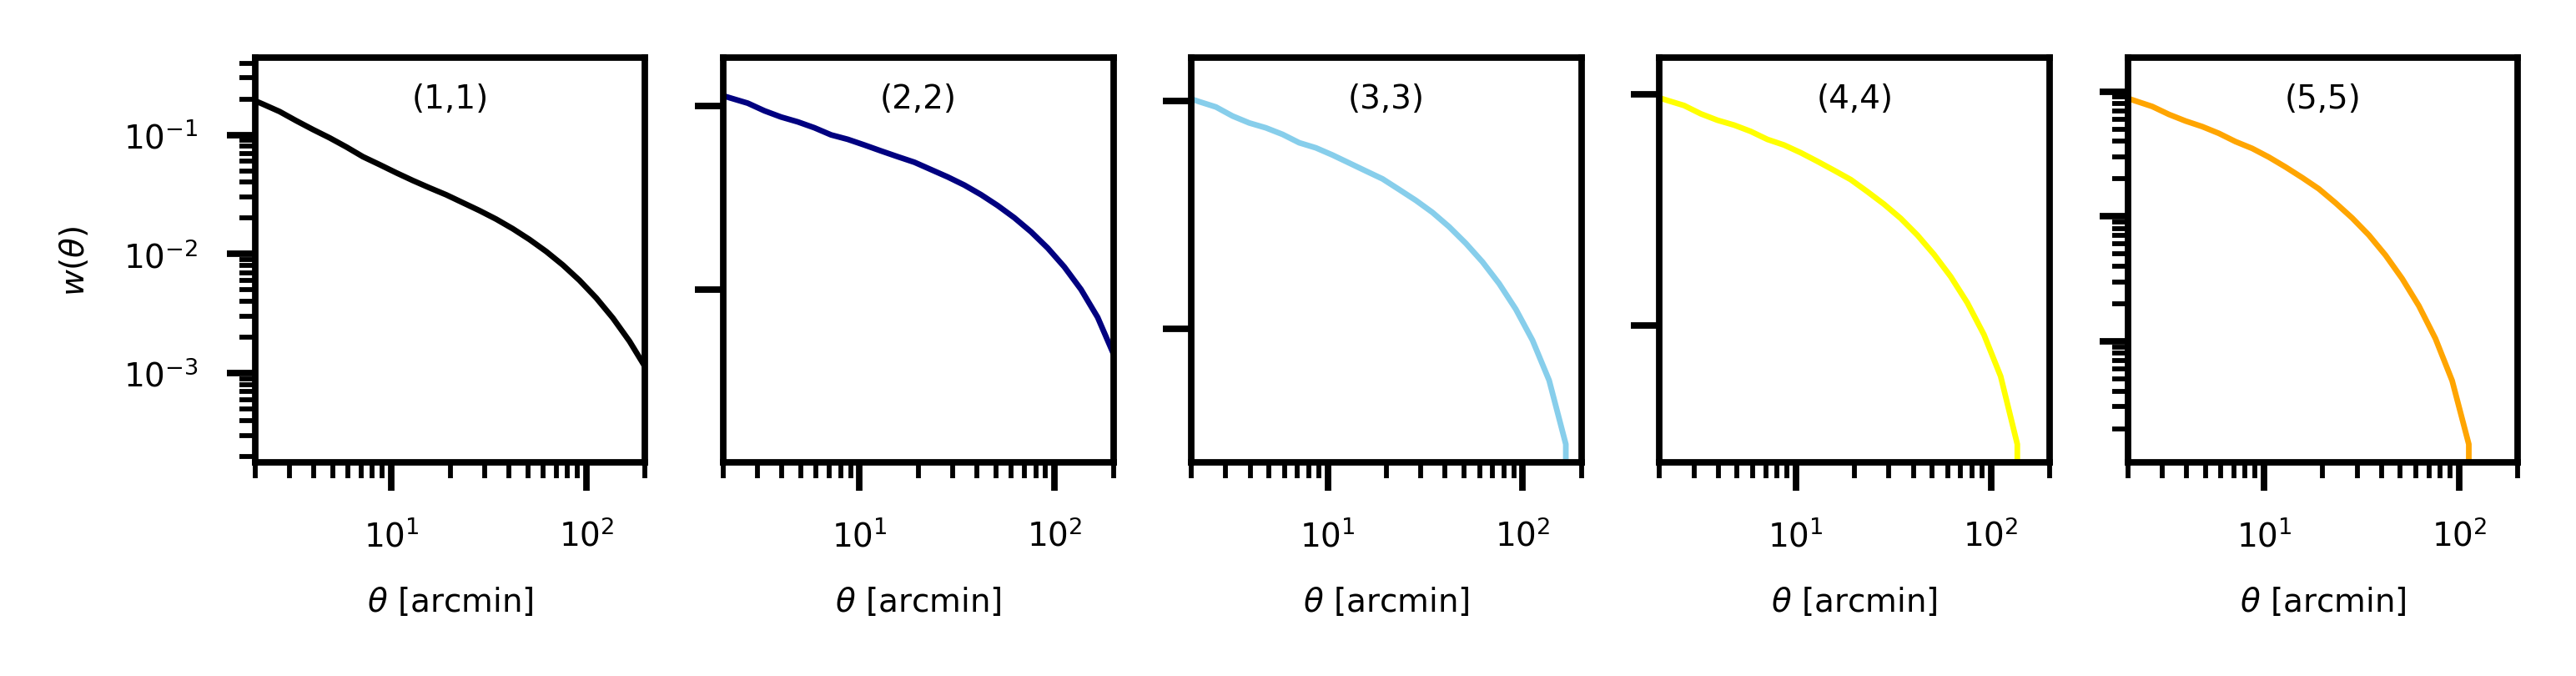

In [ ]:
# xi_gg
lw = 0.7
fs = 4
x = .5
y= .9

plt.figure(figsize=(5,0.9), dpi=700)

# xi_gg_11
plt.subplot(1,5,1)
plt.text(x, y, '(1,1)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NN"]["11"], linewidth=lw, color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.ylabel(r'$w(\theta)$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

# C_gg_22
plt.subplot(1,5,2)
plt.text(x, y, '(2,2)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NN"]["22"], linewidth=lw, color='navy')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.gca().set_yticklabels([])
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

# C_gg_33
plt.subplot(1,5,3)
plt.text(x, y, '(3,3)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NN"]["33"], linewidth=lw, color='skyblue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.gca().set_yticklabels([])
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

# C_gg_44
plt.subplot(1,5,4)
plt.text(x, y, '(4,4)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NN"]["44"], linewidth=lw, color='yellow')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.gca().set_yticklabels([])
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

# C_gg_55
plt.subplot(1,5,5)
plt.text(x, y, '(5,5)', ha='center', va='center', transform=plt.gca().transAxes, fontsize=fs)
plt.plot(theta_minutes, xi_dict["NN"]["55"], linewidth=lw, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [arcmin]', fontsize = fs)
plt.gca().set_yticklabels([])
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(2,2.e2)

plt.show()


In [17]:
#########  Covariance Matrix  ##########

!pip install tjpcov

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.7/363.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 35.8 MB/s eta 0:00:00
  Created wheel for sacc: filename=sacc-0.14-py3-none-any.whl size=32726 sha256=6a549381fb29d9d6c174d906f89d688061336ee3340763ef5d608aedb3d45fbe
  Stored in directory: /root/.cache/pip/wheels/50/9c/e8/55dfea453b41c8acfff4e814f656577af737025715468c3c24
Successfully built sacc


In [18]:
import tjpcov
from tjpcov.covariance_calculator import CovarianceCalculator

Covariance Matrix:
 [[1.56170396e-08 1.82943643e-09 1.95016683e-10 2.43142586e-10
  2.86936073e-10 2.18337131e-10 2.28632615e-11 2.85414335e-11
  3.37111136e-11 2.43835756e-12 3.04029804e-12 3.58804347e-12
  3.79116216e-12 4.47444630e-12 5.28108916e-12]
 [1.82943643e-09 3.49024134e-09 5.22703754e-10 6.94407967e-11
  9.41787769e-11 8.18935215e-10 1.04897386e-10 5.94830671e-11
  7.17829362e-11 1.27793607e-11 8.68070974e-12 1.04165634e-11
  1.72472692e-12 2.22804746e-12 2.85757893e-12]
 [1.95016683e-10 5.22703754e-10 1.97348034e-09 3.74444895e-10
  4.88883526e-11 1.25280017e-10 2.50294502e-10 5.44573424e-11
  1.52598607e-11 4.92856755e-11 3.54947145e-11 3.70694922e-11
  1.16647928e-11 7.63908146e-12 1.74288082e-12]
 [2.43142586e-10 6.94407967e-11 3.74444895e-10 1.35941578e-09
  3.20122602e-10 1.33583226e-11 4.71568975e-11 1.71166723e-10
  4.10937308e-11 9.31740390e-12 2.27866657e-11 1.08718669e-11
  4.24703315e-11 3.01120523e-11 1.17776696e-11]
 [2.86936073e-10 9.41787769e-11 4.88883526e-

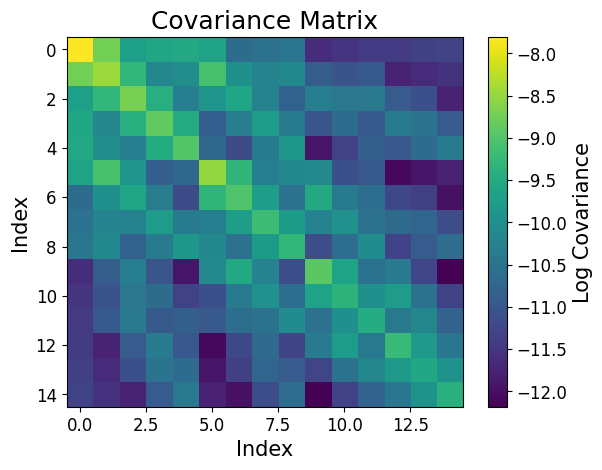

In [30]:
# Define redshift distribution function

# Define redshift bins

# Define angular scales

# Compute power spectra
st = ""
for key in C_ell_dict["GG"].keys():
  st += "GG" + key
for key in C_ell_dict["NG"].keys():
  st += "NG" + key
for key in C_ell_dict["NN"].keys():
  st += "NN" + key

cl_gg = [C_ell_dict['GG'][key] for key in C_ell_dict["GG"].keys()]
cl_gs = [C_ell_dict['NG'][key] for key in C_ell_dict["NG"].keys()]
cl_ss = [C_ell_dict['NN'][key] for key in C_ell_dict["NN"].keys()]

fsky = 0.5

# Combine power spectra into a single array
cls = np.zeros((len(cl_gg), len(ell)))
C_ell_dict_sum = {}
for key in C_ell_dict['GG'].keys():
  C_ell_dict_sum[key] = C_ell_dict['GG'][key] + C_ell_dict['NG'][key] + C_ell_dict['NN'][key]
all_cls = np.array(cls).reshape((-1, len(ell)))

# Covariance matrix calculation
# Assuming Gaussian covariance for simplicity
cov_matrix = np.zeros((len(all_cls), len(all_cls), len(ell)))


for i in range(len(all_cls)):
    for j in range(len(all_cls)):
      ix = st[i * 4 + 2]
      iy = st[i * 4 + 3]
      iz = st[j * 4 + 2]
      iw = st[j * 4 + 3]
      for l in range(len(ell)):
        if (int(ix) > int(iz)):
          ind1 = iz + ix
        else:
          ind1 = ix + iz
        if (int(iy) > int(iw)):
          ind2 = iw + iy
        else:
          ind2 = iy + iw
        if (int(ix) > int(iw)):
          ind3 = iw + ix
        else:
          ind3 = ix + iw
        if (int(iy) > int(iz)):
          ind4 = iz + iy
        else:
          ind4 = iy + iz
        cov_matrix[i, j, l] = (C_ell_dict_sum[ind1][l] * C_ell_dict_sum[ind2][l]
                               + C_ell_dict_sum[ind3][l] * C_ell_dict_sum[ind4][l]) / (2 * ell[l] + 1) / fsky

# Sum over ell bins to get the final covariance matrix
cov_matrix_sum = np.sum(cov_matrix, axis=2)

# Print or use the covariance matrix
print("Covariance Matrix:\n", cov_matrix_sum)

# Plot the covariance matrix for visualization
plt.imshow(np.log10(cov_matrix_sum), cmap='viridis', aspect='auto')
plt.colorbar(label='Log Covariance')
plt.xlabel('Index')
plt.ylabel('Index')
plt.title('Covariance Matrix')
plt.show()


In [31]:
##### Fisher Matrix ######

# Define the model parameters to estimate
param_names = ['Omega_c', 'sigma8']
param_values = [params[name] for name in param_names]

# Function to compute the observables (e.g., power spectra)
def compute_observables(cosmo):
    tracer_dict = {
      "G": [], # shear
      "N": []  # clustering
    }
    for i in range(5):
      tracer_dict["G"].append(ccl.WeakLensingTracer(cosmo, dndz=(z, bins["sources"]['1'][i])))
      tracer_dict["N"].append(ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, bins["lenses"]['1'][i]), bias=(z,b[i])))
    # dict of C_ell's without IA
    C_ell_dict = {
        "GG": {"11": [], "12": [], "13": [], "14": [], "15": [],
              "22": [], "23": [], "24": [], "25": [],
              "33": [], "34": [], "35": [],
              "44": [], "45": [],
              "55": []},
        "NG": {"11": [], "12": [], "13": [], "14": [], "15": [],
              "22": [], "23": [], "24": [], "25": [],
              "33": [], "34": [], "35": [],
              "44": [], "45": [],
              "55": []},
        "NN": {"11": [], "12": [], "13": [], "14": [], "15": [],
              "22": [], "23": [], "24": [], "25": [],
              "33": [], "34": [], "35": [],
              "44": [], "45": [],
              "55": []}
    }
    for key in C_ell_dict.keys():
      for k in C_ell_dict[key].keys():
        C_ell_dict[key][k] = ccl.angular_cl(cosmo, tracer_dict[key[0]][int(k[0])-1], tracer_dict[key[1]][int(k[1])-1], ell)
    # Define tracers, power spectra, etc.
    # Return the observables (e.g., power spectra) as an array
    # Example: return np.array([cl_gg, cl_gs, cl_ss])
    cl_gg = [C_ell_dict['GG'][key] for key in C_ell_dict["GG"].keys()]
    cl_gs = [C_ell_dict['NG'][key] for key in C_ell_dict["NG"].keys()]
    cl_ss = [C_ell_dict['NN'][key] for key in C_ell_dict["NN"].keys()]

    fsky = 0.5

    # Combine power spectra into a single array
    cls = np.zeros((len(cl_gg), len(ell)))
    C_ell_dict_sum = {}
    for key in C_ell_dict['GG'].keys():
      C_ell_dict_sum[key] = C_ell_dict['GG'][key] + C_ell_dict['NG'][key] + C_ell_dict['NN'][key]
    all_cls = np.array(cls).reshape((-1, len(ell)))

    # Covariance matrix calculation
    # Assuming Gaussian covariance for simplicity
    cov_matrix = np.zeros((len(all_cls), len(all_cls), len(ell)))


    for i in range(len(all_cls)):
        for j in range(len(all_cls)):
          ix = st[i * 4 + 2]
          iy = st[i * 4 + 3]
          iz = st[j * 4 + 2]
          iw = st[j * 4 + 3]
          for l in range(len(ell)):
            if (int(ix) > int(iz)):
              ind1 = iz + ix
            else:
              ind1 = ix + iz
            if (int(iy) > int(iw)):
              ind2 = iw + iy
            else:
              ind2 = iy + iw
            if (int(ix) > int(iw)):
              ind3 = iw + ix
            else:
              ind3 = ix + iw
            if (int(iy) > int(iz)):
              ind4 = iz + iy
            else:
              ind4 = iy + iz
            cov_matrix[i, j, l] = (C_ell_dict_sum[ind1][l] * C_ell_dict_sum[ind2][l]
                                  + C_ell_dict_sum[ind3][l] * C_ell_dict_sum[ind4][l]) / (2 * ell[l] + 1) / fsky

    # Sum over ell bins to get the final covariance matrix
    cov_matrix_sum = np.sum(cov_matrix, axis=2)
    return cov_matrix_sum

# Compute the derivatives of the observables with respect to each parameter
def compute_derivatives(cosmo, param_names, param_values, delta=1e-5):
    derivatives = []
    for i, param in enumerate(param_names):
        params_plus = params.copy()
        params_minus = params.copy()

        # Increment and decrement the parameter by a small delta
        params_plus[param] = param_values[i] + delta
        params_minus[param] = param_values[i] - delta

        # Compute the cosmologies
        cosmo_plus = ccl.Cosmology(**params_plus)
        cosmo_minus = ccl.Cosmology(**params_minus)

        # Compute the observables for the incremented and decremented parameters
        obs_plus = compute_observables(cosmo_plus)
        obs_minus = compute_observables(cosmo_minus)

        derivative = (obs_plus - obs_minus) / (2 * delta)
        derivatives.append(derivative)

    return np.array(derivatives)

# Compute the Fisher matrix
def compute_fisher_matrix(covariance_matrix, derivatives):
    inv_cov = np.linalg.inv(covariance_matrix)
    fisher_matrix = np.zeros((len(param_names), len(param_names)))

    for i in range(len(param_names)):
        for j in range(len(param_names)):
            fisher_matrix[i, j] = 0.5 * np.trace(
                inv_cov @ derivatives[i] @ inv_cov @ derivatives[j]
            )
    return fisher_matrix

derivatives = compute_derivatives(cosmo, param_names, param_values)

# Compute the Fisher matrix
fisher_matrix = compute_fisher_matrix(cov_matrix_sum, derivatives)

# Print the Fisher matrix
print("Fisher Matrix:\n", fisher_matrix)


Fisher Matrix:
 [[1383.92872107 -507.70389928]
 [-507.70389928  186.49144843]]
